In [1]:
import json
import glob

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style='darkgrid')
sns.set_palette('colorblind')
sns.set_context('talk')
%matplotlib inline

In [2]:
CONTINUOUS_FEATURE_COLUMNS = [
    "sequence_duplicates",
    "max_frequency",
    "avg_frequency",
    "min_frequency",
    "median_frequency",
    "p25_frequency",
    "p75_frequency",
    "generation_perplexity",
    "prompt_perplexity",
    "sequence_perplexity",
    "0_8_templates",
    "0_8_snowclones",
    "huffman_coding_length",
]
CATEGORICAL_FEATURE_COLUMNS = [
    # This feature needs to be derived from the dataset
    "is_templating",
]
ALL_FEATURE_COLUMNS = CONTINUOUS_FEATURE_COLUMNS + CATEGORICAL_FEATURE_COLUMNS

# Correlations

ID: run-d6-0-27
Metadata: {'sequence_duplication_threshold': 6}


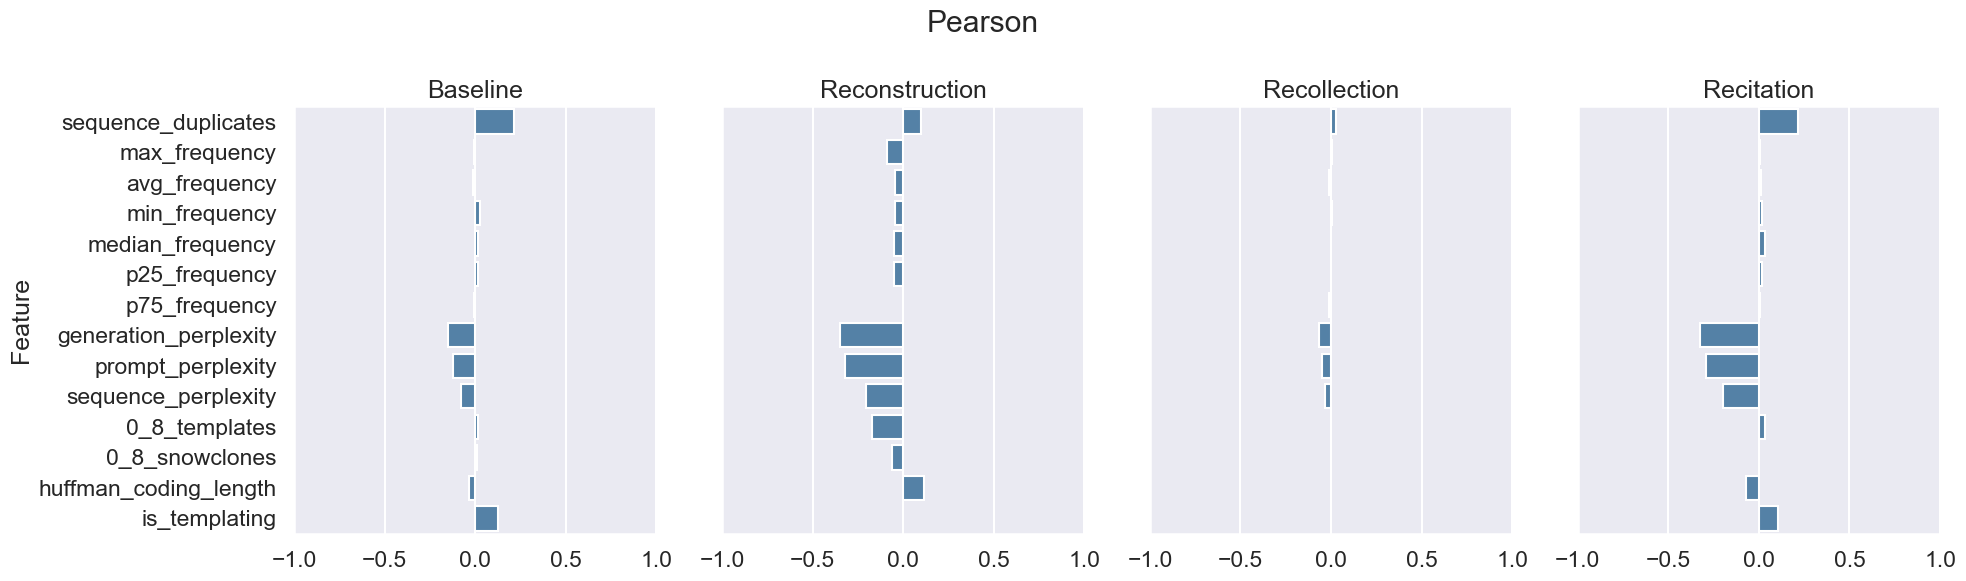

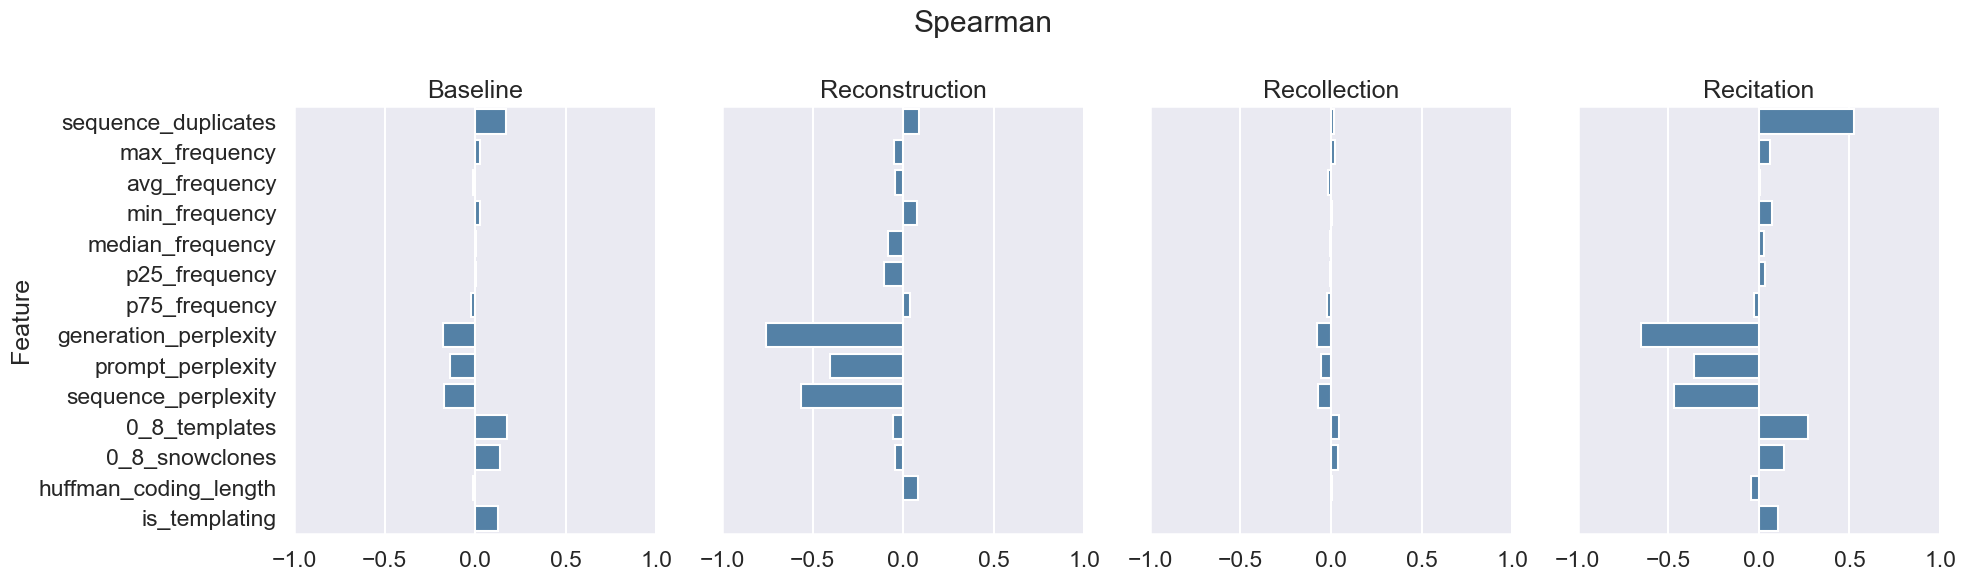

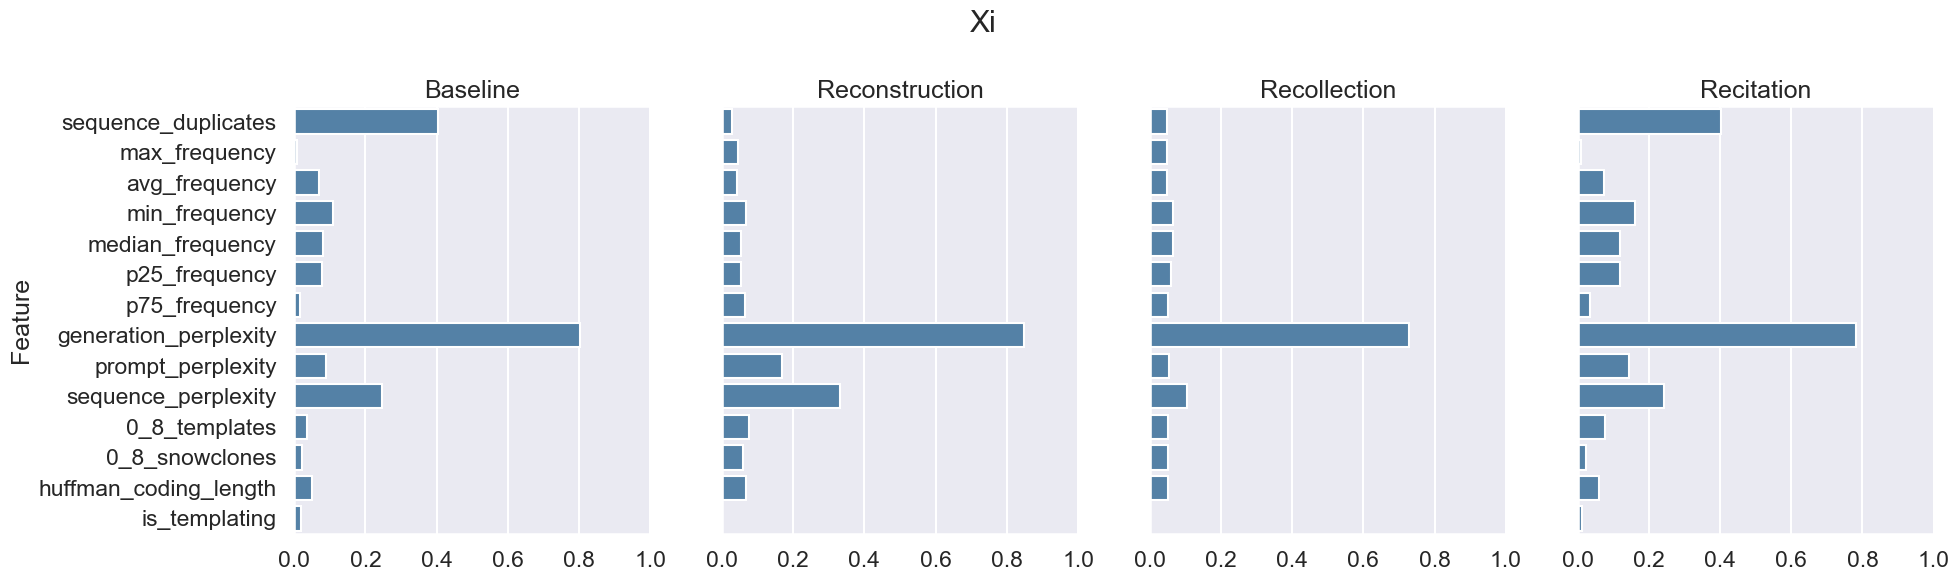

In [9]:
categories = ['baseline', 'reconstruction', 'recollection', 'recitation']
correlation_types = ['pearson', 'spearman', 'xi']
run_ids = ['run-d6-0-27']

for _id in run_ids:
    coefficients = json.load(open(f'experiments/{_id}/deduped/12b/correlation_coefficients.json'))
    print('ID:', _id)
    print('Metadata:', coefficients['metadata'])
    
    for t in correlation_types:
        fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
        
        for i, cat in enumerate(categories):
            values = [l[0] for l in coefficients[cat][t]]
            combined = list(zip(values, ALL_FEATURE_COLUMNS))
            combined = pd.DataFrame(combined, columns=['Value', 'Feature'])
            sns.barplot(data=combined, x='Value', y='Feature', ax=axs[i], color='steelblue')
            axs[i].set_title(cat.capitalize())
            axs[i].set_xlabel('')
            
            if t != 'xi':
                axs[i].set_xlim(-1.0, 1.0)
            else:
                axs[i].set_xlim(0.0, 1.0)

            if i != 0:
                axs[i].set_ylabel('')
        
        plt.suptitle(t.capitalize())
        plt.tight_layout()
        plt.show()

# Memorization Classification

In [30]:
all_runs = sorted(glob.glob('experiments/**/metadata.json', recursive=True))

In [61]:
performance_data = []

for path in all_runs:
    data = json.load(open(path))
    run_id = path.split('/')[1]
    is_taxonomy_search = 'taxonomy_search' in path
    train_roc, train_pr = data['train_roc_auc'], data['train_pr_auc']
    eval_roc, eval_pr = data['evaluation_roc_auc'], data['evaluation_pr_auc']
    eval_dataset_name = data['evaluation_dataset_type']

    if is_taxonomy_search:
        first_feature_name = data['taxonomy_1_feature_name']
        first_feature_quantile = data['taxonomy_1_threshold_quantile']
        second_feature_name = data['taxonomy_2_feature_name']
        second_feature_quantile = data['taxonomy_2_threshold_quantile']
        taxonomy_type = f'{first_feature_name}-{first_feature_quantile}/{second_feature_name}-{second_feature_quantile}'
        
        performance_data.append((run_id, taxonomy_type, is_taxonomy_search, train_roc, train_pr, eval_dataset_name, eval_roc, eval_pr))
    else:
        taxonomy_type = path.split('/')[4]
        performance_data.append((run_id, taxonomy_type, is_taxonomy_search, train_roc, train_pr, eval_dataset_name, eval_roc, eval_pr))

performance_df = pd.DataFrame(performance_data, columns=[
    'run_id', 'taxonomy_type', 'is_taxonomy_search',
    'train_roc_auc', 'train_pr_auc', 'eval_dataset_name',
    'eval_roc_auc', 'eval_pr_auc'
])

In [74]:
standard_df = performance_df[
    (performance_df.is_taxonomy_search == False) & (performance_df.run_id == 'run-d6-0-27')
]
standard_df_melted = standard_df.melt(
    id_vars=['taxonomy_type'],
    value_vars=['train_roc_auc', 'train_pr_auc', 'eval_roc_auc', 'eval_pr_auc'], 
    var_name='metric',
    value_name='score',
)

In [95]:
standard_df_melted

,taxonomy_type,metric,score
0,baseline,train_roc_auc,0.842981
1,recitation,train_roc_auc,0.533253
2,recollection,train_roc_auc,0.628041
3,reconstruction,train_roc_auc,0.582786
4,baseline,train_pr_auc,0.842981
5,recitation,train_pr_auc,0.533253
6,recollection,train_pr_auc,0.628041
7,reconstruction,train_pr_auc,0.582786
8,baseline,eval_roc_auc,0.844793
9,recitation,eval_roc_auc,0.523773


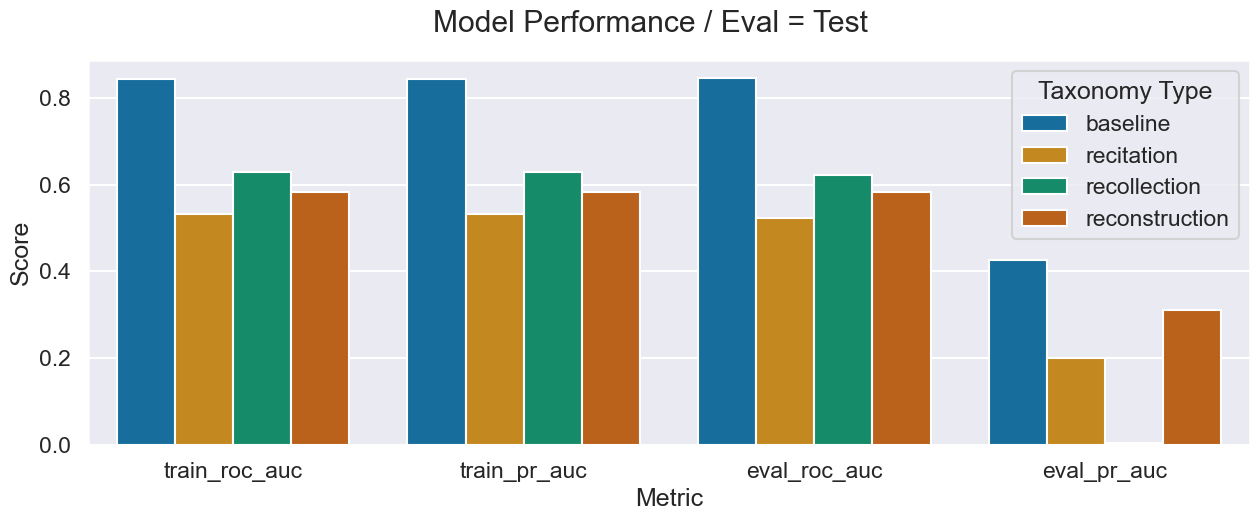

In [105]:
plt.figure(figsize=(15, 5))
sns.barplot(data=standard_df_melted, x='metric', y='score', hue='taxonomy_type')
plt.suptitle('Model Performance / Eval = Test')
plt.legend(title='Taxonomy Type')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()

In [89]:
taxonomy_df = performance_df[performance_df.is_taxonomy_search == True]

In [104]:
for _, row in taxonomy_df.sort_values('eval_pr_auc', ascending=False)[:5].iterrows():
    print('Taxonomy:', row.taxonomy_type, 'Validation PR AUC:', row.eval_pr_auc)

Taxonomy: huffman_coding_length-0.25/generation_perplexity-0.75 Validation PR AUC: 0.9904101630835263
Taxonomy: generation_perplexity-0.75/huffman_coding_length-0.25 Validation PR AUC: 0.9904101630835263
Taxonomy: huffman_coding_length-0.5/generation_perplexity-0.75 Validation PR AUC: 0.9862528713197878
Taxonomy: generation_perplexity-0.75/huffman_coding_length-0.5 Validation PR AUC: 0.9862528713197878
Taxonomy: generation_perplexity-0.75/max_frequency-0.25 Validation PR AUC: 0.9776754222531177
